In [7]:
import pandas as pd


data = pd.read_parquet('data.parquet') 


# Calculate the Spread
data['Spread'] = data['banknifty'] - data['nifty']

In [8]:
# Define a window for calculating rolling mean and std deviation
window = 20  


data['mean_spread'] = data['Spread'].rolling(window=window).mean()
data['std_spread'] = data['Spread'].rolling(window=window).std()

# Calculate the z-score
data['z_score'] = (data['Spread'] - data['mean_spread']) / data['std_spread']

# Define z-score thresholds for buy/sell signals
threshold_buy = 2  
threshold_sell = -2  

# Generate signals
data['signal'] = 0  # Initialize signal column
data.loc[data['z_score'] > threshold_buy, 'signal'] = -1  # Spread expected to decrease, sell signal
data.loc[data['z_score'] < threshold_sell, 'signal'] = 1  # Spread expected to increase, buy signal

# Shift signals to align with the next trading opportunity
data['signal'] = data['signal'].shift(-1)

# Calculate P/L for each trade
data['pnl'] = data['signal'] * data['Spread'] * (data['tte'] ** 0.7)


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Feature engineering for the advanced model
# Here, as an example, we use lagged spreads and z_scores as features
for lag in range(1, 6):  # Creating lags for 5 days
    data[f'Spread_lag_{lag}'] = data['Spread'].shift(lag)
    data[f'z_score_lag_{lag}'] = data['z_score'].shift(lag)

# Dropping rows with NaN values created by shifting
data.dropna(inplace=True)

# Defining features and target for the ML model
X = data[[f'Spread_lag_{lag}' for lag in range(1, 6)] + [f'z_score_lag_{lag}' for lag in range(1, 6)]]
y = data['signal']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy}')

# Generate signals based on the model predictions (you can refine this process based on model confidence, etc.)
# Note: For actual trading, you would train the model on the full dataset and use it to predict signals on new, unseen data.


Model Accuracy: 0.9250681850806258


In [10]:
print(data[['Spread', 'mean_spread', 'std_spread', 'z_score', 'signal']].head())

                       Spread  mean_spread  std_spread   z_score  signal
time                                                                    
2021-01-01 09:39:00  0.079362     0.082919    0.002174 -1.636475     0.0
2021-01-01 09:40:00  0.078887     0.082628    0.002307 -1.621424     0.0
2021-01-01 09:41:00  0.078010     0.082344    0.002510 -1.726869     0.0
2021-01-01 09:42:00  0.077308     0.081952    0.002657 -1.747925     0.0
2021-01-01 09:43:00  0.078512     0.081713    0.002744 -1.166560     0.0


In [11]:
print(data[['Spread', 'signal', 'pnl']].head())

                       Spread  signal  pnl
time                                      
2021-01-01 09:39:00  0.079362     0.0  0.0
2021-01-01 09:40:00  0.078887     0.0  0.0
2021-01-01 09:41:00  0.078010     0.0  0.0
2021-01-01 09:42:00  0.077308     0.0  0.0
2021-01-01 09:43:00  0.078512     0.0  0.0


In [12]:
print(f'Model Accuracy: {accuracy}')

Model Accuracy: 0.9250681850806258


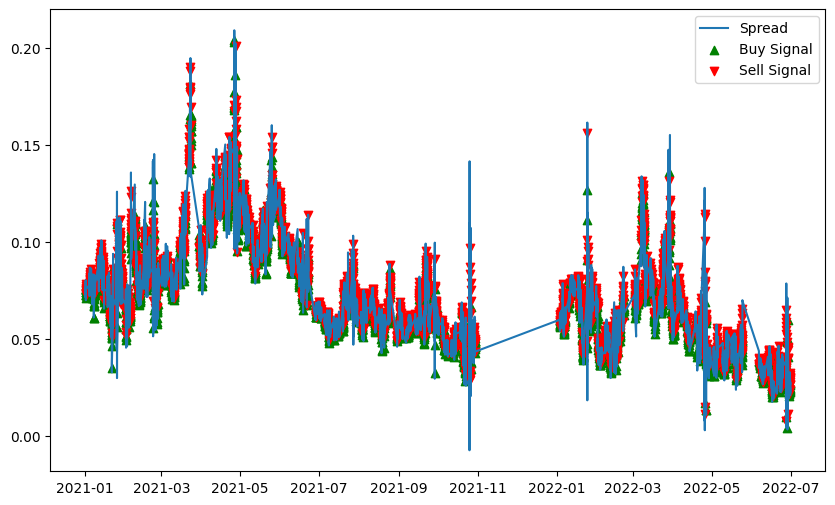

In [13]:
import matplotlib.pyplot as plt

# Plotting the Spread and Signals
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Spread'], label='Spread')
plt.scatter(data.index[data['signal'] == 1], data['Spread'][data['signal'] == 1], label='Buy Signal', marker='^', color='green')
plt.scatter(data.index[data['signal'] == -1], data['Spread'][data['signal'] == -1], label='Sell Signal', marker='v', color='red')
plt.legend()
plt.show()
